In [1]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import json

from netket import experimental as nkx

from netket.experimental.operator.fermion import (
    destroy as c,
    create as cd,
    number as n,
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# create an operator representing fermi hubbard interactions
# -t (i^ j + h.c.) + U (i^ i j^ j)
L = 4  # take a 2x2 lattice
D = 2
t = 1  # tunneling/hopping
U = 0.00  # coulomb

# create the graph our fermions can hop on
g = nk.graph.Hypercube(length=L, n_dim=D, pbc=True)
n_sites = g.n_nodes

# create a hilbert space with 2 up and 2 down spins
hi = nkx.hilbert.SpinOrbitalFermions(n_sites, s=1 / 2, n_fermions_per_spin=(2, 2))


up = +1
down = -1
ham = 0.0
for sz in (up, down):
    for u, v in g.edges():
        ham += -t * cd(hi, u, sz) * c(hi, v, sz) - t * cd(hi, v, sz) * c(hi, u, sz)
for u in g.nodes():
    ham += U * n(hi, u, up) * n(hi, u, down)

print("Hamiltonian =", ham.operator_string())

Hamiltonian = -1.0 [19^ 23] +
-1.0 [23^ 19] +
-1.0 [28^ 29] +
-1.0 [29^ 28] +
-1.0 [24^ 25] +
-1.0 [25^ 24] +
-1.0 [24^ 28] +
-1.0 [28^ 24] +
-1.0 [18^ 30] +
-1.0 [30^ 18] +
-1.0 [29^ 30] +
-1.0 [30^ 29] +
-1.0 [20^ 21] +
-1.0 [21^ 20] +
-1.0 [21^ 22] +
-1.0 [22^ 21] +
-1.0 [20^ 24] +
-1.0 [24^ 20] +
-1.0 [28^ 31] +
-1.0 [31^ 28] +
-1.0 [21^ 25] +
-1.0 [25^ 21] +
-1.0 [30^ 31] +
-1.0 [31^ 30] +
-1.0 [19^ 31] +
-1.0 [31^ 19] +
-1.0 [24^ 27] +
-1.0 [27^ 24] +
-1.0 [16^ 17] +
-1.0 [17^ 16] +
-1.0 [25^ 26] +
-1.0 [26^ 25] +
-1.0 [17^ 18] +
-1.0 [18^ 17] +
-1.0 [16^ 20] +
-1.0 [20^ 16] +
-1.0 [25^ 29] +
-1.0 [29^ 25] +
-1.0 [26^ 27] +
-1.0 [27^ 26] +
-1.0 [17^ 21] +
-1.0 [21^ 17] +
-1.0 [26^ 30] +
-1.0 [30^ 26] +
-1.0 [22^ 23] +
-1.0 [23^ 22] +
-1.0 [22^ 26] +
-1.0 [26^ 22] +
-1.0 [20^ 23] +
-1.0 [23^ 20] +
-1.0 [16^ 19] +
-1.0 [19^ 16] +
-1.0 [16^ 28] +
-1.0 [28^ 16] +
-1.0 [18^ 19] +
-1.0 [19^ 18] +
-1.0 [17^ 29] +
-1.0 [29^ 17] +
-1.0 [18^ 22] +
-1.0 [22^ 18] +
-1.0 [27^ 31] +
-1.0 [31^ 

In [2]:
L = 4  # Side of the square
graph = nk.graph.Square(L)
g = graph
N = graph.n_nodes

N_f = 1

hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=(N_f,N_f))

t = 1.0
U = 0.0

H = 0.0
for (i, j) in graph.edges():
    H -= t * (cd(hi,i,1) * c(hi,j,1) + cd(hi,j,1) * c(hi,i,1))
    H -= t * (cd(hi,i,-1) * c(hi,j,-1) + cd(hi,j,-1) * c(hi,i,-1))
for i in graph.nodes():
    H += U * n(hi,i,1) * n(hi,i,-1)
ham = H

In [4]:
import flax.linen as nn
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from netket import jax as nkjax
from typing import Any, Callable, Sequence
from functools import partial
DType = Any
import jax
import jax.numpy as jnp

In [12]:
class LogSlaterDeterminant(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    def setup(self):
        self.Mup = self.param('Mup', self.kernel_init, 
                   (self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[0]), 
                   self.param_dtype)   
        self.Mdown = self.param('Mdown', self.kernel_init, 
                   (self.hilbert.n_orbitals, self.hilbert.n_fermions_per_spin[1]), 
                   self.param_dtype) 

    @nn.compact
    def __call__(self, n):
        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Find the positions of the occupied orbitals 
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            Rup = R[0:self.hilbert.n_fermions_per_spin[0]]
            Rdown = R[self.hilbert.n_fermions_per_spin[0]:] - self.hilbert.n_orbitals
            
            # Extract the Nf x Nf submatrix of M corresponding to the occupied orbitals
            Aup = self.Mup[Rup]
            Adown = self.Mdown[Rdown]

            return nkjax.logdet_cmplx(Aup) + nkjax.logdet_cmplx(Adown)

        return log_sd(n)

In [13]:
# metropolis exchange moves fermions around according to a graph
# the physical graph has LxL vertices, but the computational basis defined by the
# hilbert space contains (2s+1)*L*L occupation numbers
# by taking a disjoint copy of the lattice, we can
# move the fermions around independently for both spins
# and therefore conserve the number of fermions with up and down spin

# g.n_nodes == L*L --> disj_graph == 2*L*L
# this is handled by netket by passing the keyword copy_per_spin=True
sa = nkx.sampler.MetropolisParticleExchange(
    hi, graph=g, n_chains=16, exchange_spins=False, sweep_size=64
)

# since the hilbert basis is a set of occupation numbers, we can take a general RBM
# we take complex parameters, since it learns sign structures more easily, and for even fermion number, the wave function might be complex
#ma = nkx.models.Slater2nd(hi, param_dtype=complex)
ma = LogSlaterDeterminant(hi, param_dtype=complex)
vs = nk.vqs.MCState(sa, ma, n_discard_per_chain=10, n_samples=512)

# we will use sgd with Stochastic Reconfiguration
opt = nk.optimizer.Sgd(learning_rate=0.01)
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)

gs = nk.driver.VMC(ham, opt, variational_state=vs, preconditioner=sr)

# now run the optimization
# first step will take longer in order to compile
exp_name = "fermions_test"
gs.run(300, out=exp_name)


100%|██████████| 300/300 [01:27<00:00,  3.44it/s, Energy=-7.999991+0.000003j ± 0.000011 [σ²=0.000000, R̂=1.0065]]


(JsonLog('fermions_test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.3760843276977539
   	Params: 0.3922286033630371,)

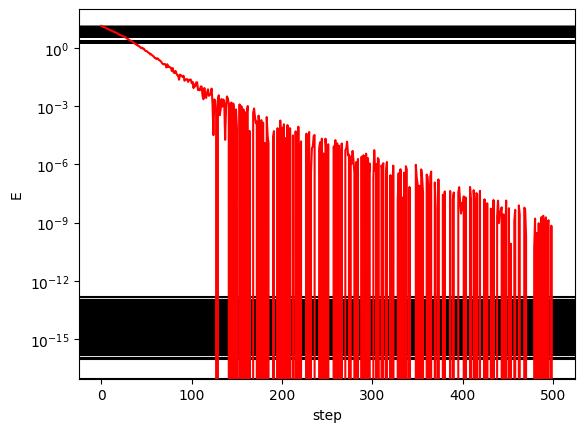

In [7]:
############## plot #################

ed_energies = np.linalg.eigvalsh(ham.to_dense())

with open(f"{exp_name}.log") as f:
    data = json.load(f)

x = data["Energy"]["iters"]
y = data["Energy"]["Mean"]["real"]

# plot the energy levels
plt.axhline(ed_energies[0], color="red", label="E0")
for e in ed_energies[1:]:
    plt.axhline(e, color="black")
plt.semilogy(x, y - ed_energies[0], color="red", label="VMC")
plt.xlabel("step")
plt.ylabel("E")
plt.show()

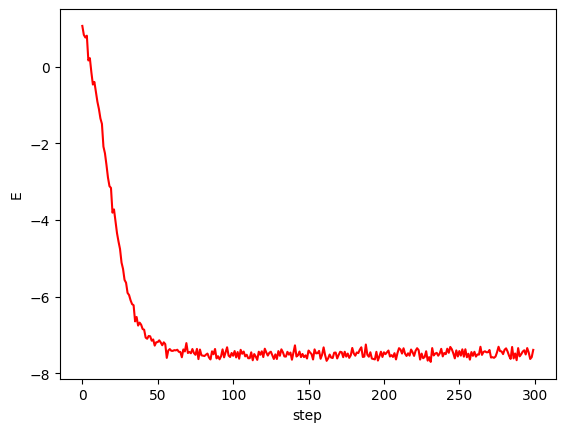

In [14]:
with open(f"{exp_name}.log") as f:
    data = json.load(f)

x = data["Energy"]["iters"]
y = data["Energy"]["Mean"]["real"]

# plot the energy levels
#plt.axhline(ed_energies[0], color="red", label="E0")
#for e in ed_energies[1:]:
#    plt.axhline(e, color="black")
plt.plot(x, y , color="red", label="VMC")
plt.xlabel("step")
plt.ylabel("E")
plt.show()